In [ ]:
# Using the SQL database approach, compare
# manta data with model results, varying
# the averaging period and the max age.


In [ ]:
import os
import time
from collections import defaultdict
import six

import logging as log
import glob
import re

from matplotlib import colors, cm
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import LogNorm

import numpy as np

import pandas as pd
import xarray as xr

from sqlite3 import dbapi2 as sql

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.spatial import proj_utils 
from stompy.model.data_comparison import calc_metrics
from stompy.plot import plot_wkb
from stompy.model import data_comparison
import stompy.plot.cmap as scmap

import postprocess_v00 as post

%matplotlib notebook

In [3]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')

In [6]:
# Load the manta data, clean it up
# This is maybe out of date - it has dups, blanks, and more missing x,y
# than what I expect.
# v01nofiber has 1 sample missing lat/lon
# v01std has 3... but those are LabBlanks. why did they get through?
# one issue is that there are some no-fiber stations where the only
# thing found was fibers, so those just go away in the nofiber case.
# should fix that!

manta=pd.read_csv('manta_summary-v02.csv')
manta.head()

,SampleID,SAMPLE LOCATION,DATE,TYPE,LAT START,LONG START,LAT END,LONG END,TOTAL DIST (M),START FLOW,...,count_std,count_nofiber,part_per_m3_std,part_per_m2_std,part_per_m3_raw,part_per_m2_raw,part_per_m3_nofiber,part_per_m2_nofiber,x,y
0,CB-4-Manta-21Aug2017,CB4,2017-08-21,Manta,37.915567,-122.441217,37.941933,-122.419983,3473.323262,NaN,...,45.125,3.125,0.224191,0.021298,0.024841,0.002360,0.015526,0.001475,550040.331073,4.198063e+06
1,SPB3-Manta-21Aug2017,SPB3,2017-08-21,Manta,38.023072,-122.371583,38.042133,-122.321883,66678.222270,9113.0,...,723.000,118.000,1.817781,0.172689,0.301706,0.028662,0.296678,0.028184,557329.971756,4.209634e+06
2,SUB1-Manta-21Aug2017,SUB1,2017-08-21,Manta,38.107067,-122.056283,38.096533,-122.064917,1393.740434,128369.0,...,NaN,10.000,NaN,NaN,0.039205,0.003724,0.032671,0.003104,582363.556136,4.217527e+06
3,SPB2-Manta-21Aug2017,SPB2,2017-08-21,Manta,38.051283,-122.421750,38.023000,-122.428117,3194.008847,220135.0,...,49.125,5.125,0.210549,0.020002,0.034288,0.003257,0.021966,0.002087,550464.046320,4.210092e+06
4,CB9-Manta-22Aug2017,CB9,2017-08-22,Manta,37.687233,-122.290917,37.698500,-122.298433,1416.656380,290000.0,...,28.125,28.125,0.085947,0.008165,0.091677,0.008709,0.085947,0.008165,562183.425087,4.171973e+06


In [14]:
import sql_common
six.moves.reload_module(sql_common)

# try to run everything that can be cached and re-used through
# here. 

<module 'sql_common' from '/home/rusty/src/microplastic_sfbay/postprocess/sql_common.py'>

In [15]:
#PtmSet=sql_common.PtmSet
#dbs=glob.glob("/opt2/sfb_ocean/ptm/all_source/*/ptm_and_grid.db")

PtmSet=sql_common.PtmSetNew
dbs=glob.glob("/opt2/sfb_ocean/ptm/all_source_020b/20*/ptm_and_grid.db")

dbs.sort()

ptm_set=PtmSet(databases=dbs)

In [16]:
con=ptm_set.db_to_con(ptm_set.databases[1])

curs=con.cursor()

In [11]:
# For each trawl, I want to query all of the particles 
# that were "nearby" at a "near time", and get their
# release time, cell, std mass, and nofiber mass.
# from there, it's postprocessing to see what subset or
# weighting of those gives the best agreement with
# part_per_m2_std and part-per_m2_raw

In [17]:
def query_particles(t_start,t_stop,
                    z_filter="and loc.z_from_surface>-0.5",
                    max_age=np.timedelta64(20,'D'), # could go to 30
                    grp_filter=""):
    epoch_start=int( utils.to_unix( t_start ) )
    epoch_stop =int( utils.to_unix( t_stop ) )
    max_age_clause=f"and (loc.time-rel.time)<{int(max_age/np.timedelta64(1,'s'))}"

    # Start with a global query -- how long does it take, and how
    # many rows?
    query=f"""
      select nofiber.part_per_m3 * rel.volume / rel.count as part_count_nofiber,
             std.part_per_m3 * rel.volume / rel.count as part_count_std,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp, load.nofiber as nofiber,
             load.std as std
        where loc.time>={epoch_start} and loc.time < {epoch_stop}
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and grp.name=nofiber.group_name 
          and grp.name=std.group_name
          and loc.cell>=0
          {max_age_clause}
          {z_filter}
          {grp_filter}"""
    print(query)    
    
    query_dtype=[('count_nofiber',np.float64),
                 ('count_std',np.float64),
                 ('time',np.int32),
                 ('rel_time',np.int32),
                 ('cell',np.int32)]

    all_data=[]
    all_data.append( np.zeros(0,dtype=query_dtype) )

    for db in ptm_set.databases:
        con=ptm_set.db_to_con(db)
        ptm_set.setup_loads(con,'nofiber')
        ptm_set.setup_loads(con,'std',clean=False)

        curs=con.cursor()
        curs.execute(query)
        data=curs.fetchall()
        print(f"{db} {len(data)} rows")
        if len(data)==0: continue
        adata=np.array(data)

        adata2=np.zeros(len(adata),dtype=query_dtype)
        adata2['count_nofiber']=adata[:,0]
        adata2['count_std']=adata[:,1]

        adata2['time']=adata[:,2].astype(np.int32)
        adata2['rel_time']=adata[:,3].astype(np.int32)
        adata2['cell']=adata[:,4].astype(np.int32)
        all_data.append(adata2)

    # 114k in db[0]
    # 52846, in 14k unique cells in db[1]
    combined=np.concatenate( all_data )
    return combined


In [18]:
out_dir="manta_sets_20191203"
os.makedirs(out_dir,exist_ok=True)

for idx,rec in manta.iterrows():
    #fn=os.path.join(out_dir,f"{rec.SampleID}.npy")
    # since we're just pulling out whole days, cache by day.
    fn=os.path.join(out_dir,f"v01-{rec.DATE}.npy")
    
    if os.path.exists(fn):
        print(f"{fn} exists. Skipping")
        continue
    
    t_sample=np.datetime64(rec.DATE)
    # we don't really have times for the samples.
    # start roughly at midnight, PST, of the day of sampling
    # remembering that the model is in UTC
    t_start=t_sample+np.timedelta64(8,'h')
    # and go for a tidal day
    t_stop =t_start+np.timedelta64(25,'h')

    combined=query_particles(t_start,t_stop)
    np.save(fn,combined)



      select nofiber.part_per_m3 * rel.volume / rel.count as part_count_nofiber,
             std.part_per_m3 * rel.volume / rel.count as part_count_std,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp, load.nofiber as nofiber,
             load.std as std
        where loc.time>=1503302400 and loc.time < 1503392400
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and grp.name=nofiber.group_name 
          and grp.name=std.group_name
          and loc.cell>=0
          and (loc.time-rel.time)<1728000
          and loc.z_from_surface>-0.5
          
memory table wasn't there.  no worries.
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170720/ptm_and_grid.db 0 rows
memory table wasn't there.  no worries.
maybe the memory table was already atta

maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180205/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180215/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180225/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180307/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180317/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180327/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180406/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180416/ptm_and_grid.db 0 rows
manta_sets_20191203/v01-2017-08-22.npy exists. Skipping
manta_sets_20191203/v01-2017-08-22.npy e

maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180205/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180215/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180225/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180307/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180317/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180327/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180406/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180416/ptm_and_grid.db 0 rows
manta_sets_20191203/v01-2017-08-24.npy exists. Skipping
manta_sets_20191203/v01-2017-08-24.npy e

maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180225/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180307/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180317/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180327/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180406/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180416/ptm_and_grid.db 0 rows

      select nofiber.part_per_m3 * rel.volume / rel.count as part_count_nofiber,
             std.part_per_m3 * rel.volume / rel.count as part_count_std,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell
        from particle_loc as loc, particle as p, ptm_release as rel, 
 

maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180317/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180327/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180406/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180416/ptm_and_grid.db 0 rows
manta_sets_20191203/v01-2017-09-13.npy exists. Skipping
manta_sets_20191203/v01-2017-09-13.npy exists. Skipping
manta_sets_20191203/v01-2017-09-13.npy exists. Skipping

      select nofiber.part_per_m3 * rel.volume / rel.count as part_count_nofiber,
             std.part_per_m3 * rel.volume / rel.count as part_count_std,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp, load.nofiber as nofiber,
   

maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20180416/ptm_and_grid.db 0 rows
manta_sets_20191203/v01-2017-09-27.npy exists. Skipping
manta_sets_20191203/v01-2017-09-27.npy exists. Skipping

      select nofiber.part_per_m3 * rel.volume / rel.count as part_count_nofiber,
             std.part_per_m3 * rel.volume / rel.count as part_count_std,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp, load.nofiber as nofiber,
             load.std as std
        where loc.time>=1509868800 and loc.time < 1509958800
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and grp.name=nofiber.group_name 
          and grp.name=std.group_name
          and loc.cell>=0
          and (loc.time-rel.time)<1728000
          and loc.z_from_surface>-0.5
          
maybe t

maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170730/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170809/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170819/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170829/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170908/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170918/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170928/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171008/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171018/ptm_an

maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170819/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170829/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170908/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170918/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170928/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171008/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171018/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171028/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171107/ptm_an

maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170819/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170829/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170908/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170918/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170928/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171008/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171018/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171028/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171107/ptm_an

maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170819/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170829/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170908/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170918/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20170928/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171008/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171018/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171028/ptm_and_grid.db 0 rows
maybe the memory table was already attached?
/opt2/sfb_ocean/ptm/all_source_020b/20171107/ptm_an

In [19]:
g=ptm_set.grid()

In [20]:
# just preload all of the particle data:
# going to use a good bit of memory...
@memoize.memoize()
def load_particles(date):
    particle_fn=os.path.join(out_dir,f"v01-{date}.npy")
    particles=np.load(particle_fn)
    return particles

In [21]:
@memoize.memoize()
def stencil0(c):
    stencil=np.zeros(g.Ncells(),np.float64)
    stencil[c]=1.0
    return stencil

@memoize.memoize()
def stencil1(c):
    return ptm_set.smooth(stencil0(c))
   

In [22]:
# 0.2 seconds or less 
import time
def extract_for_sample(rec,smooth=0,tau_s=-1):
    t0=time.time()
    def tok(msg=''):
        print(f"{msg} elapsed {time.time()-t0}")
        
    particles=load_particles(rec.DATE)
    c_select=ptm_set.grid().select_cells_nearest(np.r_[rec.x,rec.y])
    age_s=particles['time']-particles['rel_time']
    if tau_s>0:
        weights=np.exp(-age_s/tau_s) * particles['count_nofiber']
    else:
        weights=particles['count_nofiber']
    
    cell_counts=np.bincount( particles['cell'], weights=weights,
                             minlength=g.Ncells())
    nsteps=25 
    cell_conc=cell_counts/g.cells_area()/nsteps

    stencil=stencil0(c_select)
    M=ptm_set.Msmooth()
    for s in range(smooth):
        stencil=M.dot(stencil)
    conc=(stencil*cell_conc).sum()
    return conc
        
extract_for_sample(rec)

smooths=[0,1,2,3,4,5,10,15,20]
taus=np.array([0.5,1,2,3,4,5,10,15,20]) * 86400.
all_results=[]
for smooth in smooths:
    for tau in taus:
        # 1 or 2 smooth makes a big improvement in spearman.
        # nothing helps r, bias or amp.
        pred=manta.apply(lambda rec: extract_for_sample(rec,smooth=smooth,tau_s=tau),
                         axis=1)
        obs=manta['part_per_m2_nofiber']

        metrics=calc_metrics( xr.DataArray(pred), xr.DataArray(obs))
        metrics['smooth']=smooth
        metrics['tau']=tau
        metrics['dataset']='nofiber'
        all_results.append(metrics)
        

INFO:utils:58582/99089


In [26]:
vers='20191203'

In [23]:
df=pd.DataFrame(all_results)
df.to_csv(f"parameter-scan-{vers}.csv")

In [24]:
df=pd.read_csv(f'parameter-scan-{vers}.csv')
df['tau_d']=df.tau/86400.

In [25]:
import seaborn as sns

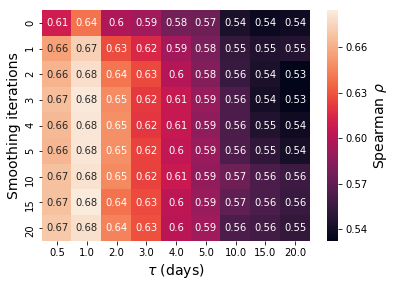

In [27]:
field='spearman_rho'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

fig,ax=plt.subplots(1,1)
hm=sns.heatmap(as_matrix, annot=True)
ax.set_xlabel(r'$\tau$ (days)',fontsize=14)
ax.set_ylabel('Smoothing iterations',fontsize=14)
cax=fig.axes[1]
cax.set_ylabel(r'Spearman $\rho$',fontsize=14)
plt.subplots_adjust(bottom=0.15,top=0.95,right=0.9)
fig.savefig(f'manta_compare_spearman_rho-{vers}.png',dpi=150)

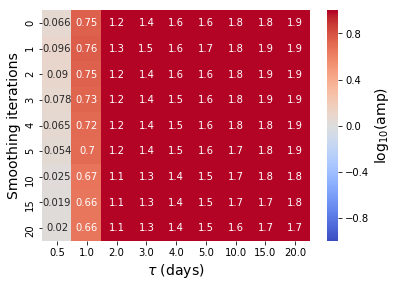

In [28]:
df['log_amp']=np.log10(df.amp)
field='log_amp'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

fig,ax=plt.subplots(1,1)

hm=sns.heatmap(as_matrix, annot=True,cmap='coolwarm',ax=ax,
               cbar_kws=dict(label=field),vmin=-1,vmax=1)
plt.subplots_adjust(bottom=0.15,top=0.95,right=0.9)
ax.set_xlabel(r'$\tau$ (days)',fontsize=14)
ax.set_ylabel('Smoothing iterations',fontsize=14)
cax=fig.axes[1]
cax.set_ylabel('log$_{10}$(amp)',fontsize=14)
fig.savefig(f'manta_compare_log10amp={vers}.png',dpi=150)


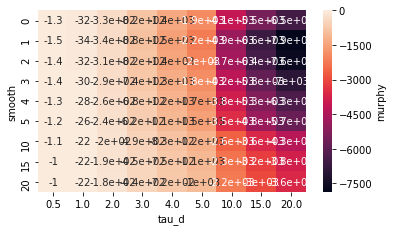

In [29]:
field='murphy'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

plt.figure()
hm=sns.heatmap(as_matrix, annot=True,cbar_kws=dict(label=field))
plt.subplots_adjust(bottom=0.25)

In [ ]:

# for baseline reference, what concentration do I get
# from this directly?
cell_counts=np.zeros(g.Ncells(),np.float64)
for count,time,rel_time,cell in combined:
    cell_counts[int(cell)]+=count
nsteps=4 # [-2,+2] hours
cell_conc=cell_counts/g.cells_area()/nsteps

In [ ]:
fig=plt.figure()
ax=plt.gca()

clim=[1e-4,100]
ccoll=g.plot_cells(values=cell_conc.clip(clim[0]),
                   norm=LogNorm(vmin=clim[0],vmax=clim[1],clip=True),
                   cmap='jet',ax=ax)
ccoll.set_clim(clim)
ax.axis('equal')

In [ ]:
# relate that back to the sample:
c_select=ptm_set.grid().select_cells_nearest(np.r_[rec.x,rec.y])

stencil=np.zeros(g.Ncells(),np.float64)
stencil[c_select]=1.0
stencil1=ptm_set.smooth(stencil)
conc0=(stencil*cell_conc).sum()
conc1=(stencil1*cell_conc).sum()

print(f"No smoothing, predicted: {conc0:.5f} particles/m2")
print(f"Smoothed, predicted      {conc1:.5f} particles/m2")
print(f"Observed, no-fiber       {rec['part_per_m2_nofiber']:.5f} particles/m2")

In [ ]:
# show how bad a straight up comparison is:

pred=manta.apply(lambda rec: extract_for_sample(rec,smooth=0,tau_s=20*86400),
                 axis=1)
obs=manta['part_per_m2_nofiber']

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.loglog( obs, pred, 'g.',ms=7 )

ax.set_ylabel('Model')
ax.set_xlabel('Observed')
fig.tight_layout()
fig.savefig('scatter-depression.png',dpi=150)

In [ ]:
pred=manta.apply(lambda rec: extract_for_sample(rec,smooth=10,tau_s=2*86400),
                 axis=1)
obs=manta['part_per_m2_nofiber']

fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.loglog( obs, pred, 'g.',ms=7 )

ax.set_ylabel('Model')
ax.set_xlabel('Observed')
fig.tight_layout()
fig.savefig('scatter-betterest.png',dpi=150)

In [ ]:
np.corrcoef(np.log10(obs.clip(1e-5)),
            np.log10(pred.clip(1e-5)))